In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/AI_Class/datakelulusanmahasiswa.xlsx'
df = pd.read_excel(file_path)


In [ ]:
print("Dataset shape:", df.shape)
print("\n5 baris pertama:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (379, 15)

5 baris pertama:
                      NAMA JENIS KELAMIN STATUS MAHASISWA  UMUR  \
0           ANIK WIDAYANTI     PEREMPUAN          BEKERJA    28   
1  DWI HESTYNA PRIHASTANTY     PEREMPUAN        MAHASISWA    32   
2       MURYA ARIEF BASUKI     PEREMPUAN          BEKERJA    29   
3            NANIK SUSANTI     PEREMPUAN        MAHASISWA    27   
4        RIFKA ISTIQFARINA     PEREMPUAN          BEKERJA    29   

    STATUS NIKAH  IPS 1  IPS 2  IPS 3  IPS 4  IPS 5  IPS 6  IPS 7  IPS 8  \
0  BELUM MENIKAH   2.76   2.80   3.20   3.17   2.98   3.00   3.03    0.0   
1  BELUM MENIKAH   3.00   3.30   3.14   3.14   2.84   3.13   3.25    0.0   
2  BELUM MENIKAH   3.50   3.30   3.70   3.29   3.53   3.72   3.73    0.0   
3  BELUM MENIKAH   3.17   3.41   3.61   3.36   3.48   3.63   3.46    0.0   
4  BELUM MENIKAH   2.90   2.89   3.30   2.85   2.98   3.00   3.08    0.0   

   IPK  STATUS KELULUSAN  
0  3.07        TERLAMBAT  
1  3.17        TERLAMBAT  
2  3.54        T

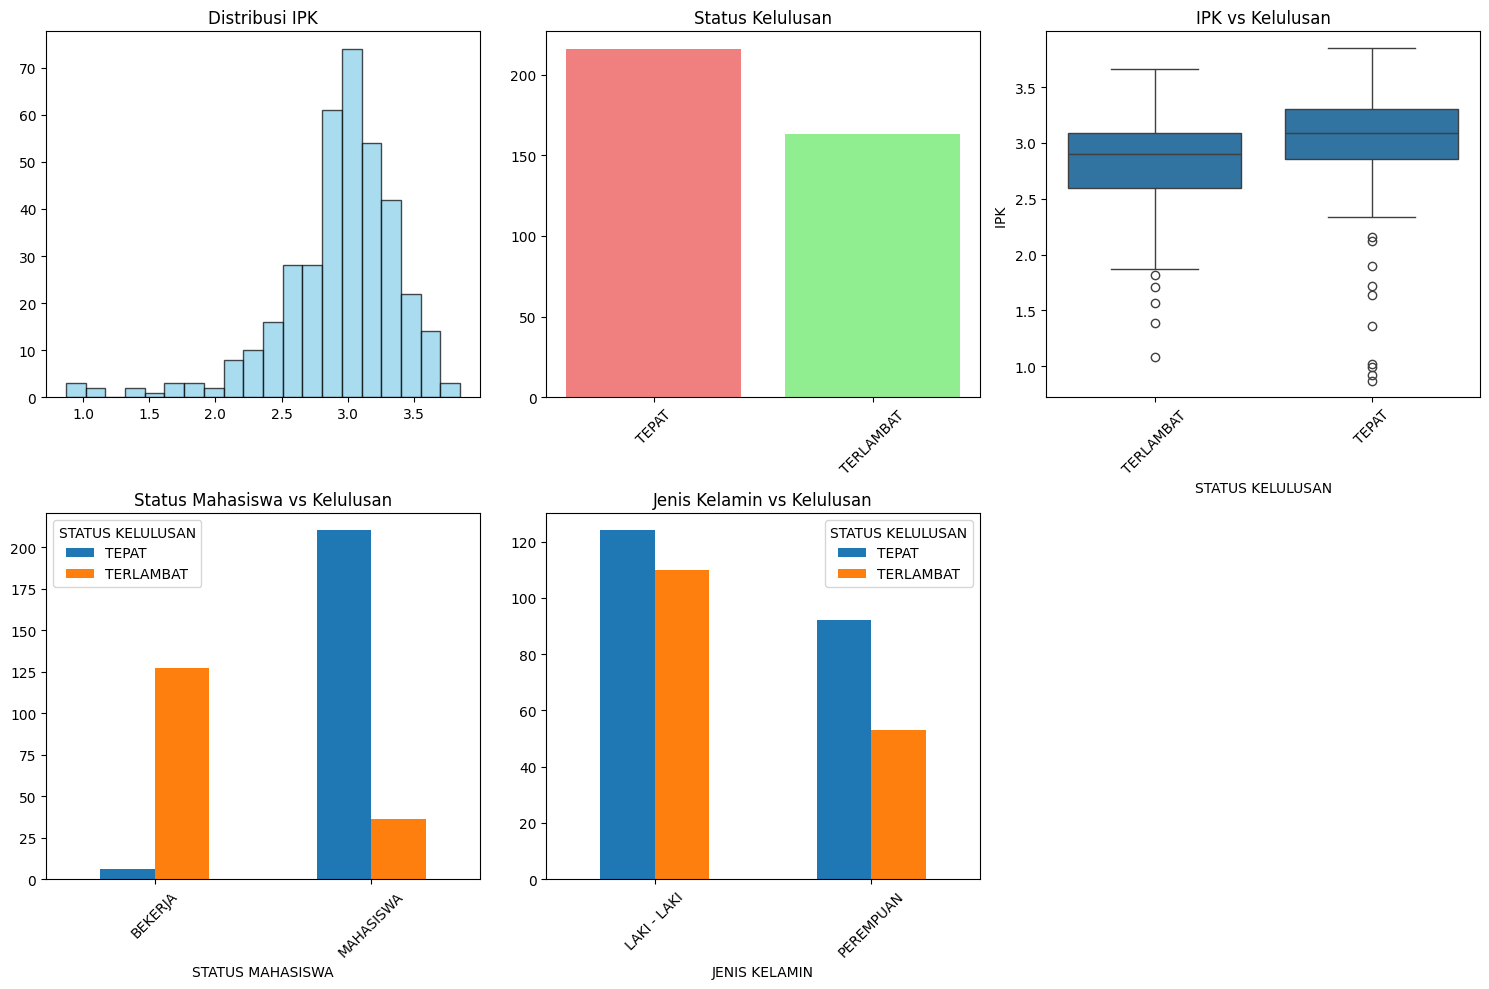

Statistik IPK berdasarkan Kelulusan:
                  count      mean       std   min   25%   50%   75%   max
STATUS KELULUSAN                                                         
TEPAT             213.0  3.026995  0.466919  0.87  2.86  3.09  3.30  3.85
TERLAMBAT         163.0  2.810368  0.422326  1.08  2.60  2.90  3.09  3.66


In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.hist(df['IPK '].dropna(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribusi IPK')

plt.subplot(2, 3, 2)
status_counts = df['STATUS KELULUSAN'].value_counts()
plt.bar(status_counts.index, status_counts.values, color=['lightcoral', 'lightgreen'])
plt.title('Status Kelulusan')
plt.xticks(rotation=45)

plt.subplot(2, 3, 3)
sns.boxplot(x='STATUS KELULUSAN', y='IPK ', data=df)
plt.title('IPK vs Kelulusan')
plt.xticks(rotation=45)

plt.subplot(2, 3, 4)
status_mhs_counts = pd.crosstab(df['STATUS MAHASISWA'], df['STATUS KELULUSAN'])
status_mhs_counts.plot(kind='bar', ax=plt.gca())
plt.title('Status Mahasiswa vs Kelulusan')
plt.xticks(rotation=45)

plt.subplot(2, 3, 5)
jk_counts = pd.crosstab(df['JENIS KELAMIN'], df['STATUS KELULUSAN'])
jk_counts.plot(kind='bar', ax=plt.gca())
plt.title('Jenis Kelamin vs Kelulusan')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("Statistik IPK berdasarkan Kelulusan:")
print(df.groupby('STATUS KELULUSAN')['IPK '].describe())

In [ ]:
# Preprocessing data
numeric_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

imputer_numeric = SimpleImputer(strategy='median')
df[numeric_cols] = imputer_numeric.fit_transform(df[numeric_cols])

imputer_categorical = SimpleImputer(strategy='most_frequent')
df[categorical_cols] = imputer_categorical.fit_transform(df[categorical_cols])

print("Missing values setelah handling:", df.isnull().sum().sum())

Missing values setelah handling: 0


In [ ]:
# Feature selection - gunakan kolom yang sesuai
features = ['IPK ', 'UMUR', 'STATUS MAHASISWA', 'JENIS KELAMIN', 'STATUS NIKAH']
X = df[features]
y = df['STATUS KELULUSAN']

print("Features yang digunakan:", features)

Features yang digunakan: ['IPK ', 'UMUR', 'STATUS MAHASISWA', 'JENIS KELAMIN', 'STATUS NIKAH']


In [ ]:
# Encoding variabel kategorikal
label_encoders = {}
for col in ['STATUS MAHASISWA', 'JENIS KELAMIN', 'STATUS NIKAH']:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Encoded STATUS MAHASISWA: {'BEKERJA': np.int64(0), 'MAHASISWA': np.int64(1)}
Encoded JENIS KELAMIN: {'LAKI - LAKI': np.int64(0), 'PEREMPUAN': np.int64(1)}
Encoded STATUS NIKAH: {'BELUM MENIKAH': np.int64(0), 'MENIKAH': np.int64(1)}


In [ ]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Training set: 303 samples
Test set: 76 samples


In [ ]:
# Training SVM model
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['linear', 'rbf']
}

svm = SVC(random_state=42)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV score: 0.8843715846994537


In [ ]:
# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8947368421052632
Confusion Matrix:
[[42  1]
 [ 7 26]]
Classification Report:
              precision    recall  f1-score   support

       TEPAT       0.86      0.98      0.91        43
   TERLAMBAT       0.96      0.79      0.87        33

    accuracy                           0.89        76
   macro avg       0.91      0.88      0.89        76
weighted avg       0.90      0.89      0.89        76



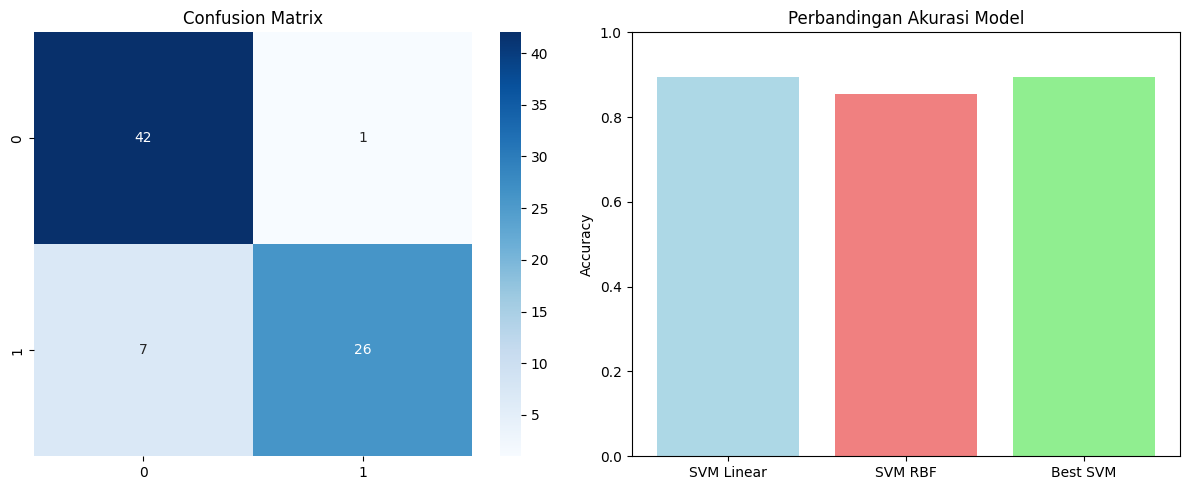

In [ ]:
# Visualisasi hasil
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')

plt.subplot(1, 2, 2)
models = ['SVM Linear', 'SVM RBF', 'Best SVM']
svm_linear = SVC(kernel='linear', random_state=42)
svm_rbf = SVC(kernel='rbf', random_state=42)

svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)

acc_linear = accuracy_score(y_test, svm_linear.predict(X_test))
acc_rbf = accuracy_score(y_test, svm_rbf.predict(X_test))
accuracies = [acc_linear, acc_rbf, accuracy]

plt.bar(models, accuracies, color=['lightblue', 'lightcoral', 'lightgreen'])
plt.title('Perbandingan Akurasi Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [ ]:
# Fungsi prediksi
def predict_status(ipk, umur, status_mahasiswa, jenis_kelamin, status_nikah):
    input_data = pd.DataFrame({
        'IPK ': [ipk],
        'UMUR': [umur],
        'STATUS MAHASISWA': [status_mahasiswa],
        'JENIS KELAMIN': [jenis_kelamin],
        'STATUS NIKAH': [status_nikah]
    })

    for col in ['STATUS MAHASISWA', 'JENIS KELAMIN', 'STATUS NIKAH']:
        if col in label_encoders:
            input_data[col] = label_encoders[col].transform([input_data[col].iloc[0]])

    input_scaled = scaler.transform(input_data)
    prediction = best_svm.predict(input_scaled)

    return prediction[0]


In [ ]:
# Test fungsi prediksi
print("Testing prediction function:")
test_cases = [
    (3.5, 22, 'MAHASISWA', 'PEREMPUAN', 'BELUM MENIKAH'),
    (2.8, 28, 'BEKERJA', 'LAKI - LAKI', 'BELUM MENIKAH'),
    (2.2, 35, 'BEKERJA', 'LAKI - LAKI', 'MENIKAH')
]

for i, (ipk, umur, status_mhs, jk, status_nikah) in enumerate(test_cases, 1):
    result = predict_status(ipk, umur, status_mhs, jk, status_nikah)
    print(f"Test {i}: IPK={ipk}, Umur={umur}, Status={status_mhs}, JK={jk}, Nikah={status_nikah}")
    print(f"   → Prediksi: {result}\n")


Testing prediction function:
Test 1: IPK=3.5, Umur=22, Status=MAHASISWA, JK=PEREMPUAN, Nikah=BELUM MENIKAH
   → Prediksi: TEPAT

Test 2: IPK=2.8, Umur=28, Status=BEKERJA, JK=LAKI - LAKI, Nikah=BELUM MENIKAH
   → Prediksi: TERLAMBAT

Test 3: IPK=2.2, Umur=35, Status=BEKERJA, JK=LAKI - LAKI, Nikah=MENIKAH
   → Prediksi: TERLAMBAT



In [ ]:
# Install joblib untuk save model
!pip install joblib

import joblib


In [ ]:
 #Save model dan preprocessing objects
model_artifacts = {
    'model': best_svm,
    'scaler': scaler,
    'label_encoders': label_encoders,
    'features': features
}